## Importing all modules in cell below.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from typing import Callable, Iterable

## Load dataset

In [2]:
data = np.loadtxt('../support/zipcombo.dat')
# data = np.loadtxt('../support/dtrain123.dat')

In [3]:
data.shape

(9298, 257)

We now define functions for splitting the dataset into train/test and input/label.

In [4]:
def split_80_20(data: np.ndarray) -> (np.ndarray, np.ndarray):
    """
    Splits 80% train 20% test

    :param data: sequence.
    :return: train_data, test_data: np.ndarray, np.ndarray
    """

    n = data.shape[0]
    train_size = int(n*0.8)
    return data[:train_size], data[train_size:]

In [5]:
def split_X_y(data: np.ndarray) -> (np.ndarray, np.ndarray):
    """
    Splits the data into datapoints and labels, X_train matrix and y_train;
    :param data: np.ndarray
    :return: X_train, y_train: np.ndarray, np.ndarray
    """

    return data[:, 1:], data[:, 0]

In [6]:
def shuffle_split(data):
    # np.random.seed(seed)
    shuffled = np.random.permutation(data)
    data_train, data_test = split_80_20(shuffled)
    X_train, y_train = split_X_y(data_train)
    X_test, y_test = split_X_y(data_test)

    assert X_train.shape[0] == y_train.size
    assert X_test.shape[0] == y_test.size

    print("Train data set size = %d" % X_train.shape[0])
    print("Test data set size = %d" % X_test.shape[0])

    return X_train, y_train, X_test, y_test

In [9]:
X_train, y_train, X_test, y_test = shuffle_split(data)

Train data set size = 7438
Test data set size = 1860


In [7]:
def display_digit(grayscale):
    plt.imshow(np.reshape(grayscale, (16, 16)), cmap='gray')

4.0


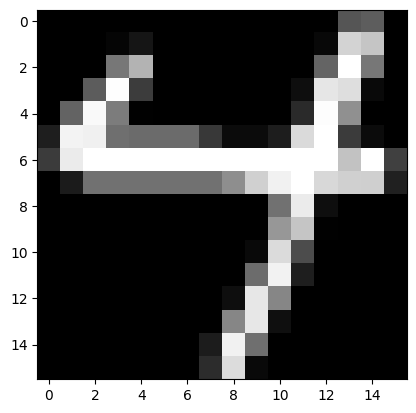

In [10]:
display_digit(X_train[100])
print(y_train[100])

Let us now define the Kernel Perceptron algorithm and kernel functions to be used.

In [11]:
def polynomial_kernel(x_i: np.ndarray, x_t: np.ndarray, d: int):
    return np.inner(x_i, x_t) ** d

In [12]:
def gaussian_kernel(x_i: np.ndarray, x_j: np.ndarray, sigma=1):
    if x_i.shape[0] != x_j.shape[0]:
        raise Exception("Cannot apply kernel to vectors of different dimensions: x_i has shape {s1}, x_j has shape {s2}"
                        .format(s1=x_i.shape, s2=x_j.shape))
    diff = x_i - x_j
    return np.exp(-1 * np.inner(diff, diff) / (2 * sigma**2))

In [34]:
class KernelPerceptron:
    def __init__(self, kernel: Callable[[np.ndarray, np.ndarray], float], size: int):
        self.kernel = kernel
        self.K = None
        self.alpha = np.zeros(size)
        self.X_train = None

    def _get_kernel_matrix(self, X_train: np.ndarray) -> np.ndarray:
        K = np.zeros((X_train.shape[0], X_train.shape[0]))

        for i in range(0, X_train.shape[0]):
            for j in range(i, X_train.shape[0]):
                K[i, j] = K[j, i] = self.kernel(X_train[i], X_train[j])

        return K

    def fit(self, X_train: np.ndarray, y_train: np.ndarray, n_epochs: int) -> np.ndarray:
        """
        Prediction function that populates the alpha parameter, 1 data point at a time;
        :param X_train: training data points
        :param y_train: training corresponding labels
        :param n_epochs: number of times to pass through the data. Alpha contains the learning parameters that get inherited from one epoch to the other
        :return: y_preds: the predictions enhanced after N epochs

        """
        if y_train.ndim != 1:
            raise Exception('y_train must be a 1-dim np.ndarray. Given y_train with shape {s}'.format(s=y_train.shape))
        if X_train.shape[0] != y_train.size:
            raise Exception('X_train and y_train must contain equal number of samples. Given X_train with shape {s1} and y_train with shape {s2}'.format(s1=y_train.shape, s2=X_train.shape))

        y_preds = np.zeros(X_train.shape[0])
        self.X_train = X_train

        # Compute kernel matrix which stays constant throughout the algorithm and all epochs
        self.K = self._get_kernel_matrix(X_train)

        for epoch in range(0, n_epochs):
            for t in range(0, X_train.shape[0]):
                y_pred = self._predict_single(t)
                y_preds[t] = y_pred
                if y_pred != y_train[t]:
                    self.alpha[t] += y_train[t]
        return y_preds

    def _predict_single(self, t: int):
        """
        We take a whole row of kernel matrix K because in we want to account for errors in previous epochs.
        This is not an issue in the first epoch because all alpha's > t are 0.
        :param t: iteration step in the online learning algorithm.
        :return: y hat, single predicted value at step t.
        """
        return np.sign(np.inner(self.K[t, :], self.alpha))

    def yhat_single(self, K, t: int):
        return np.sign(np.inner(K[t, :], self.alpha))

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Prediction function to be used for out-of-sample test data point.
        Does not perform online learning (update step).
        :param X: test data points.
        :return: np.ndarray of predictions for each given test data point.
        """
        predictions = []
        for x_test in X:
            sum = 0
            for t in range(self.X_train.shape[0]):
                # Can improve by using kernel matrix
                sum += self.alpha[t] * self.kernel(self.X_train[t], x_test)
            predictions.append(np.sign(sum))
        return np.array(predictions)


# kp = KernelPerceptron(kernel=partial(polynomial_kernel, d=3))
# y_insample = kp.fit(X_train_12, y_train_12, n_epochs=2)

In [15]:
def get_error_percentage_old(y_train, y_insample, y_test, y_outsample):
    training_error = 100 * get_num_mistakes(actual=y_train, predicted=y_insample) / y_train.size
    test_errors = 100 * get_num_mistakes(actual=y_test, predicted=y_outsample) / y_test.size
    print("in-sample = % " + str(training_error))
    print("out-of-sample = % " + str(test_errors))
    return training_error, test_errors

def get_error_percentage(y, y_preds):
    error = 100 * get_num_mistakes(actual=y, predicted=y_preds) / y.size
    print("in-sample = % " + str(error))
    return error

def get_num_mistakes(actual: np.ndarray, predicted: np.ndarray) -> int:
    # or calculating by checking which alpha values are different than 0? alpha is 0 when the prediction matches
    diffs = actual - predicted
    n_mistakes = 0
    for diff in diffs:
        if diff != 0:
            n_mistakes += 1
    return n_mistakes

class KPOneVsAllClassifier:
    def __init__(self, kernel, n_classes, d):
        self.kernel = kernel
        self.n_classes = n_classes # could optimize to remove this var since =k.shape[0]
        self.d = d
        self.X_train = None
        self.Alpha = None
        self.K = None

    def _get_kernel_matrix(self, X_train: np.ndarray) -> np.ndarray:
        ### TODO: Takes a lot of time, we should improve efficiency
        # K = np.zeros((X_train.shape[0], X_train.shape[0]))
        # for i in range(0, X_train.shape[0]):
        #     for j in range(i, X_train.shape[0]):
        #         K[i, j] = K[j, i] = self.kernel(X_train[i], X_train[j], d=self.d)
        # return K
        return np.power(X_train @ X_train.T, self.d)

    def sign(self, x: np.ndarray) -> np.ndarray:
        return np.where(x <= 0, -1, 1)

    def _predict_single_confidence(self, t, y_train):
        # Get prediction array P
        # preds = (self.Alpha @ self.K)[:, t]
        preds = self.Alpha @ self.K[t]

        # Get Y_t array of ground truth (duplicate y_t)
        y = np.full(self.n_classes, -1)
        y[int(y_train[t])] = 1

        # penilize
        # how should the alpha look like on miss on y=7 ? 1 1 1 1 1 1 1 -1 1 1 (only 7 is penilized?) or -1 -1 ... -1 (everybody is penilized
        # should we only penilize the respective perceptron? e.g., if y=7, and perceptron[7]=0, should we penilize just perceptron 7?
        self.Alpha[:, t] -= np.heaviside(-(preds * y), 1) * self.sign(preds)
        return preds
        # for each perceptron
        # for cl in range(self.n_classes):
        #     # create and save predictions
        #     pred = np.inner(self.K[t, :], perceptrons[cl].alpha)
        #     confidence[cl] = pred
        #
        #     y = 1 if y_train[t] == float(cl) else (-1)
        #     ## penalize if the prediction wrong
        #     if y*pred <= 0:
        #         perceptrons[cl].alpha[t] -= self.sign(pred)

    def fit(self, X_train, y_train, n_epochs):
        y_preds = np.array(np.zeros(X_train.shape[0]))

        self.K = self._get_kernel_matrix(X_train)
        self.Alpha = np.zeros((self.n_classes, X_train.shape[0]))
        self.X_train = X_train

        for epoch in range(n_epochs):
            # for each point, calculate confidence and make predictions
            for t in range(0, X_train.shape[0]):
                confidence = self._predict_single_confidence(t, y_train)
                # the index with the highest number(confidence) is the prediction
                # +1 because the index for confidence in perceptron[1] is 0
                y_preds[t] = np.argmax(confidence) + 1
        return y_preds

    # def _choose_best_ytest(self, yhats):
    #     # get the classifiers that predicted positive
    #     maxims = np.argwhere(yhats == np.amax(yhats)).flatten() + 1
    #     if maxims.shape[0] == 1:
    #         # if only 1 classifier predicts positive, take that class
    #          return maxims[0]
    #     else:
    #         # if more than one predicted positive, or all of them negative, choose one randomly
    #         return np.random.choice(maxims)

    def predict(self, X_test: np.ndarray):
        ## for polynomial kernel
        self.K_test = np.power(X_train @ X_test.T, self.d)
        return np.argmax((self.Alpha @ self.K_test), axis=0)
        #
        # for t_test in range(X_test.shape[0]):
        #     yhats_sums = self.Alpha @ self.K_test[t_test]
        #     ypreds[t_test] = self._choose_best_ytest(yhats_sums)
        #     yhats_sums = np.array(np.zeros(self.n_classes))
        #     for cl in range(self.n_classes):
        #         # update
        #         sum = np.inner(self.Alpha[:, t])
        #         for t in range(self.X_train.shape[0]):
        #             sum += self.perceptrons[cl].alpha[t] * self.kernel(self.X_train[t], X_test[t_test], self.d)
        #         yhats_sums[cl] = sum
        # return ypreds


### for in-cell debug
# import time
#
# start = time.time()
#
# kpova = KPOneVsAllClassifier(polynomial_kernel, n_classes=10, d=3)
# kpova.fit(X_train, y_train, n_epochs=50)
# y_insample = kpova.predict(X_train)
# y_outsample = kpova.predict(X_test)
#
# end = time.time()
#
# print("took :{t}".format(t=end-start))
#
# get_error_percentage(y_train, y_insample, y_test, y_outsample)

In [ ]:
X_test[1]

In [58]:
import time

start = time.time()

kpova = KPOneVsAllClassifier(polynomial_kernel, n_classes=10, d=3)
kpova.fit(X_train, y_train, n_epochs=1)
y_insample = kpova.predict(X_train)
y_outsample = kpova.predict(X_test)

end = time.time()

print("took :{t}".format(t=end-start))

get_error_percentage(y_train, y_insample, y_test, y_outsample)

took :4.681886434555054
in-sample = % 2.030115622479161
out-of-sample = % 4.193548387096774


(2.030115622479161, 4.193548387096774)

### _Tests_

Let us test the Kernel Perceptron implementation on a dummy dataset of only digits 1 and 2.

In [18]:
# Filter out digit 3 (leave only digit 1 and 2) from dtrain123.dat train and test dataset
indxs_digit_3 = np.where(y_train_123 == 3)
X_train_12 = np.delete(X_train_123, indxs_digit_3, axis=0)
y_train_12 = np.delete(y_train_123, indxs_digit_3)
y_train_12[y_train_12 == 1] = -1
y_train_12[y_train_12 == 2] = 1

indxs_digit_3 = np.where(y_test_123 == 3)
X_test_12 = np.delete(X_test_123, indxs_digit_3, axis=0)
y_test_12 = np.delete(y_test_123, indxs_digit_3)
y_test_12[y_test_12 == 1] = -1
y_test_12[y_test_12 == 2] = 1

assert X_train_12.shape[0] == y_train_12.size
assert X_test_12.shape[0] == y_test_12.size

In [21]:
# Test fitting and in-sample predictions
kp = KernelPerceptron(kernel=partial(polynomial_kernel, d=5), size=X_train_12.shape[0])
y_insample = kp.fit(X_train_12, y_train_12, n_epochs=2)
# Test out-of-sample predictions
y_outsample = kp.predict(X_test_12) # all predictions of test sample in y_outsample
print("in-sample = % " + str(100 * get_num_mistakes(actual=y_train_12, predicted=y_insample) / y_train_12.size))
print("out-of-sample = % " + str(100 * get_num_mistakes(actual=y_test_12, predicted=y_outsample) / y_test_12.size))

in-sample = % 0.0
out-of-sample = % 1.8518518518518519


In [69]:
## Test the kernel matrix
kp_test = KernelPerceptron(kernel=partial(polynomial_kernel, d=3))
kernel_matrix = kp_test._get_kernel_matrix(X_train_12)
polynomial_kernel(X_train_12[0], X_train_12[0], d=3) == kernel_matrix[0][0]

TypeError: KernelPerceptron.__init__() missing 1 required positional argument: 'size'

# *_Part 1_*

### 1. *Basic results*
- for $d=1, ... ,7$ perform 20 runs
- split $zipcombo$ 80-20
- report MSE and STD
- yield a 2x7 table that has on each cell $mean+-std$


In [25]:
import time

means_train = []
means_test = []
stds_train = []
stds_test = []

start=time.time()
for d in range(1, 8):
    train_errors = []
    test_errors = []
    for run in range(20):
        X_train, y_train, X_test, y_test = shuffle_split(data)

        kpova = KPOneVsAllClassifier(polynomial_kernel, n_classes=10, d=d)

        #train
        kpova.fit(X_train, y_train, n_epochs=1)
        y_insample = kpova.predict(X_train)
        #test
        y_outsample = kpova.predict(X_test)

        print('\nd=' + str(d) + ' on run ' + str(run))
        train_errors.append(get_error_percentage(y_train, y_insample))
        test_errors.append(get_error_percentage(y_test, y_outsample))
    means_train.append(np.mean(train_errors))
    means_test.append(np.mean(test_errors))
    stds_train.append(np.std(train_errors))
    stds_test.append(np.std(test_errors))
end = time.time()

print('took {t}'.format(t=end-start))

Train data set size = 7438
Test data set size = 1860

d=1 on run 0
in-sample = % 8.26835170744824
in-sample = % 8.978494623655914
Train data set size = 7438
Test data set size = 1860

d=1 on run 1
in-sample = % 8.765797257327238
in-sample = % 10.10752688172043
Train data set size = 7438
Test data set size = 1860

d=1 on run 2
in-sample = % 13.310029577843506
in-sample = % 14.731182795698924
Train data set size = 7438
Test data set size = 1860

d=1 on run 3
in-sample = % 9.854799677332617
in-sample = % 11.075268817204302
Train data set size = 7438
Test data set size = 1860

d=1 on run 4
in-sample = % 10.110244689432642
in-sample = % 10.806451612903226
Train data set size = 7438
Test data set size = 1860

d=1 on run 5
in-sample = % 10.217800484001076
in-sample = % 11.129032258064516
Train data set size = 7438
Test data set size = 1860

d=1 on run 6
in-sample = % 8.053240118311374
in-sample = % 9.731182795698924
Train data set size = 7438
Test data set size = 1860

d=1 on run 7
in-sample 

In [27]:
import pandas as pd

table_1a = pd.DataFrame({
    'mean train': [str(f'{x:.3f}') + u"\u00B1" + str(f'{y:.3f}') for (x, y) in zip(means_train, stds_train)],
    'mean test': [str(f'{x:.3f}') + u"\u00B1" + str(f'{y:.3f}') for (x, y) in zip(means_test, stds_test)],
})

display(table_1a)
table_1a.style.to_latex('table_1a.tex')

### _But firstly we need to find how many epochs to train_
#### *i.e. A discussion of any parameters of your method which were not cross-validated over.*

I ran the basic results algorithm on all $d$s only with 1 epoch in order to observe the "best" $d$ for 1 epoch on this dataset and get an intuition.

Now I will create a graph that shows the errors for each number of epochs, setting $d=[5, 7]$, plotting the average errors observed per epoch.
In order to offset the risk of being biased on a specific order of training datapoints, we will shuffle and split the dataset 20 times and average those per epoch. Each time an epoch analysis(1-15), a new classifier is defined for each nr of epochs, to show the progress individually.


In [25]:

errors_per_d = []

for d in range(5, 8):
    print('\nD = {d}'.format(d=d))
    epoch_train_errors = np.array(np.zeros((20, 15))) # size 20, 15
    epoch_test_errors = np.array(np.zeros((20, 15))) # size 20, 15

    for run in range(20):
        print('\n   RUN {r}'.format(r=run))
        X_train, y_train, X_test, y_test = shuffle_split(data)

        train_errors = np.array(np.zeros(15)) # size 15
        test_errors = np.array(np.zeros(15)) #size 15
        for n_epochs in range(1, 15):
            print('\n           EPOCH {e}'.format(e=n_epochs))
            kpova = KPOneVsAllClassifier(polynomial_kernel, n_classes=10, d=d)
            #train
            kpova.fit(X_train, y_train, n_epochs=n_epochs)
            y_insample = kpova.predict(X_train)
            #test
            y_outsample = kpova.predict(X_test)

            train_errors[n_epochs-1] = (get_error_percentage(y_train, y_insample))
            test_errors[n_epochs-1] = (get_error_percentage(y_test, y_outsample))
        epoch_train_errors[run] = train_errors
        epoch_test_errors[run] = test_errors
    # take the mean of 20 runs for every n_epoch = per columns
    errors_per_d.append((epoch_train_errors.mean(axis=0), epoch_test_errors.mean(axis=0)))





D = 5

   RUN 0
Train data set size = 7438
Test data set size = 1860

           EPOCH 1
in-sample = % 1.4923366496369992
in-sample = % 3.817204301075269

           EPOCH 2
in-sample = % 0.5243344985211078
in-sample = % 3.3870967741935485

           EPOCH 3
in-sample = % 0.26888948642108096
in-sample = % 2.903225806451613

           EPOCH 4
in-sample = % 0.1478892175315945
in-sample = % 2.849462365591398

           EPOCH 5
in-sample = % 0.04033342296316214
in-sample = % 2.795698924731183

           EPOCH 6
in-sample = % 0.026888948642108095
in-sample = % 2.6344086021505375

           EPOCH 7


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

for errors_d in errors_per_d:
    train_errors, test_errors = errors_d

    x = [epoch for epoch in range(1, 15)]

    fig = plt.figure()
    plt.title('Errors per epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Error%')
    plt.plot(x, train_errors, color = "red", linewidth = 1.5, linestyle = "-.", label = "train errors")
    plt.plot(x, test_errors, marker = '+', linestyle = '-', label = 'test_errors')
    plt.legend(loc = "upper left")
    plt.show()


### 2. _Cross validation_
- perform 20 runs
- shuffle and split data 80-20
- select "best" parameter $d*$ using 5-fold cross-validation on the 80% training data
- retrain on full 80% training using $d*$
- record the test errors for 20%
- findings: 20 $d*$ and 20 test errors
- output: mean_test_error$\pm$std, mean_$d*\pm$std

In [28]:
def cross_validation(X, y, n_folds):
    fold_size = X.shape[0] // n_folds

    split_idxs = [i * fold_size - 1 for i in range(1, 5)]
    X_folds_list = np.split(X, indices_or_sections=split_idxs)
    y_folds_list = np.split(y, indices_or_sections=split_idxs)
    assert len(X_folds_list) == len(y_folds_list) == n_folds

    errors_d = []
    for d in range(1, 8):
        local_errors = []
        for i in range(n_folds):
            # Create a training and test folds from given data
            X_train_fold = np.vstack(([X_folds_list[k] for k in range(0, n_folds) if k != i]))
            y_train_fold = np.concatenate([y_folds_list[k] for k in range(0, n_folds) if k != i], axis=0)
            X_validation_fold = X_folds_list[i]
            y_validation_fold = y_folds_list[i]

            kp = KPOneVsAllClassifier(polynomial_kernel, n_classes=10, d=d)
            kp.fit(X_train_fold, y_train_fold)
            y_preds = kp.predict(X_validation_fold)
            local_errors.append(get_error_percentage(y_validation_fold, y_preds))

        errors_d.append(local_errors)

    # errors[index + 1] = d, where d==index
    np.argmax(np.mean(errors_d, axis=1))
    return best_d


In [29]:
best_ds = []
test_errors = []

for runs in range(2):
    shuffled = np.random.permutation(data)
    train_data, test_data = split_80_20(shuffled)
    X_train, y_train = split_X_y(train_data)
    X_test, y_test = split_X_y(test_data)

    best_d = cross_validation(X_train, y_train, 5)

    kpova = KPOneVsAllClassifier(polynomial_kernel, n_classes=10, d=best_d)
    kpova.fit(X_train, y_train)
    y_outsample = kpova.predict(X_test)
    test_error = get_error_percentage(y_test, y_outsample)

    best_ds.append(best_d)
    test_errors.append(test_error)

str(f'{np.mean(best_ds):.3f}') + u"\u00B1" + str(f'{np.std(best_ds):.3f}')
str(f'{np.mean(test_errors):.3f}') + u"\u00B1" + str(f'{np.std(test_errors):.3f}')

TypeError: KPOneVsAllClassifier.fit() missing 1 required positional argument: 'n_epochs'